In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_pie_chart(counter, title):
    labels = counter.keys()
    sizes = counter.values()

    plt.figure()  # 创建新的图形
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # 确保饼图是圆的
    plt.title(title)

In [3]:
import os

os.environ["all_proxy"] = "http://127.0.0.1:10808"

import importlib
importlib.reload(os)

<module 'os' from '/usr/lib/python3.10/os.py'>

In [4]:
import json

from datasets import load_dataset


ds = load_dataset("princeton-nlp/SWE-bench")
ds

/home/llm/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    dev: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 225
    })
    test: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 2294
    })
    train: Dataset({
        features: ['repo', 'instance_id', 'base_commit', 'patch', 'test_patch', 'problem_statement', 'hints_text', 'created_at', 'version', 'FAIL_TO_PASS', 'PASS_TO_PASS', 'environment_setup_commit'],
        num_rows: 19008
    })
})

# Count the issue with images


- instance_id: A formatted instance identifier, usually as repo_owner__repo_name-PR-number.
- base_commit: The commit hash of the repository representing the HEAD of the repository BEFORE the solution PR is applied.
- patch: The gold patch, the patch generated by the PR (exclude the test-related code), that resolved the issue.
- test_patch: A test-file patch that was contributed by the solution PR.
- problem_statement: The issue (correspond the PR) title and body
- hints_text: Comments of target issue
- created_at: Creation time of the PR
- version: Installation version to use for running evaluation.
- FAIL_TO_PASS: A list (json array) of strings that represent the tests resolved by the PR and tied to the issue resolution. (new tests added in the solution PR)
- PASS_TO_PASS: A json list of strings that represent tests that should pass before and after the PR application.
- environment_setup_commit: commit hash to use for environment setup and installation. (the commit hash of next release version (with the PR and ensure it can be executed))

In [5]:
ds['test'][1]

{'repo': 'astropy/astropy',
 'instance_id': 'astropy__astropy-12057',
 'base_commit': 'b6769c18c0881b6d290e543e9334c25043018b3f',
 'patch': 'diff --git a/astropy/nddata/nduncertainty.py b/astropy/nddata/nduncertainty.py\n--- a/astropy/nddata/nduncertainty.py\n+++ b/astropy/nddata/nduncertainty.py\n@@ -395,6 +395,40 @@ def _propagate_multiply(self, other_uncert, result_data, correlation):\n     def _propagate_divide(self, other_uncert, result_data, correlation):\n         return None\n \n+    def represent_as(self, other_uncert):\n+        """Convert this uncertainty to a different uncertainty type.\n+\n+        Parameters\n+        ----------\n+        other_uncert : `NDUncertainty` subclass\n+            The `NDUncertainty` subclass to convert to.\n+\n+        Returns\n+        -------\n+        resulting_uncertainty : `NDUncertainty` instance\n+            An instance of ``other_uncert`` subclass containing the uncertainty\n+            converted to the new uncertainty type.\n+\n+   

In [12]:
import re
imgUrlPattern = re.compile(r'!\[image\]\((https?:\/\/[^\s]+)\)')

def contains_img_url(s: str, output_img_url=False) -> bool:
    matches = imgUrlPattern.findall(s)
    if matches:
        if output_img_url:
            for match in matches:
                print(match)
        return True
    return False


def count_imgs_in_cols(target_ds, cols=['problem_statement', 'hints_text']):
    ret = 0
    for i, dct in enumerate(target_ds):
        for col_name in cols:
            if contains_img_url(dct[col_name]):
                ret += 1
                break
    return ret


cnt_img_dev = count_imgs_in_cols(ds['dev'])
cnt_img_test = count_imgs_in_cols(ds['test'])
print("instance with img in data['dev']: ", cnt_img_dev)
print("instance with img in data['test']: ", cnt_img_test)

# ratio of img:
print(f"ratio of image in data['dev']: {cnt_img_dev / len(ds['dev']):.2%}")
print(f"ratio of image in data['test']: {cnt_img_test / len(ds['test']):.2%}")

instance with img in data['dev']:  12
instance with img in data['test']:  73
ratio of image in data['dev']: 5.33%
ratio of image in data['test']: 3.18%


# Describe the install versions of SWE-bench

> PS: same answer compared to "describe the environment_setup_commit of SWE-bench"

In [13]:
def describe_install_versions(target_ds):
    stat_dct = dict()
    for dct in target_ds:
        install_version = dct['repo'] + '-' + dct['version']
        if install_version not in stat_dct:
            stat_dct[install_version] = 1
        else:
            stat_dct[install_version] += 1
    sorted_stat_dct = dict(sorted(stat_dct.items()))
    for key, value in sorted_stat_dct.items():
        print(f"{key}: {value}")
    print(f'count of versions: {len(sorted_stat_dct)}')

print("describe the versions in  data['dev']:\n")
describe_install_versions(ds['dev'])
print("\n\n\ndescribe the versions in data['test']:\n")
describe_install_versions(ds['test'])

describe the versions in  data['dev']:

marshmallow-code/marshmallow-2.18: 1
marshmallow-code/marshmallow-2.19: 1
marshmallow-code/marshmallow-2.20: 2
marshmallow-code/marshmallow-3.0: 2
marshmallow-code/marshmallow-3.12: 1
marshmallow-code/marshmallow-3.19: 1
marshmallow-code/marshmallow-3.9: 1
pvlib/pvlib-python-0.5: 1
pvlib/pvlib-python-0.6: 4
pvlib/pvlib-python-0.7: 10
pvlib/pvlib-python-0.8: 36
pvlib/pvlib-python-0.9: 12
pydicom/pydicom-1.2: 8
pydicom/pydicom-1.3: 16
pydicom/pydicom-1.4: 7
pydicom/pydicom-2.0: 6
pydicom/pydicom-2.1: 9
pydicom/pydicom-2.2: 6
pydicom/pydicom-2.3: 4
pylint-dev/astroid-2.10: 4
pylint-dev/astroid-2.12: 3
pylint-dev/astroid-2.13: 4
pylint-dev/astroid-2.14: 2
pylint-dev/astroid-2.15: 4
pylint-dev/astroid-2.5: 7
pylint-dev/astroid-2.6: 1
pylint-dev/astroid-2.7: 1
pylint-dev/astroid-2.9: 2
pylint-dev/astroid-3.0: 3
pyvista/pyvista-0.22: 1
pyvista/pyvista-0.38: 4
pyvista/pyvista-0.39: 5
pyvista/pyvista-0.40: 3
pyvista/pyvista-0.41: 1
pyvista/pyvista-0.42: 1

So, the docker images we should prepared: 
- 51 docker images in dev stage,  
- 126 docker images in test (submission) stages

# Describe the repositories of SWE-bench

describe the data['dev']:

marshmallow-code/marshmallow: 9
pvlib/pvlib-python: 63
pydicom/pydicom: 56
pylint-dev/astroid: 31
pyvista/pyvista: 16
sqlfluff/sqlfluff: 50



describe the data['test']:

astropy/astropy: 95
django/django: 850
matplotlib/matplotlib: 184
mwaskom/seaborn: 22
pallets/flask: 11
psf/requests: 44
pydata/xarray: 110
pylint-dev/pylint: 57
pytest-dev/pytest: 119
scikit-learn/scikit-learn: 229
sphinx-doc/sphinx: 187
sympy/sympy: 386


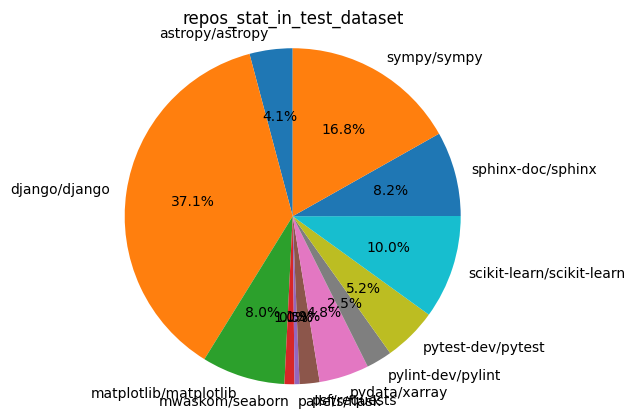

In [14]:
def describe_repositories(target_ds, plot=False, plot_title=''):
    stat_dct = dict()
    
    for dct in target_ds:
        repo = dct['repo']
        if repo not in stat_dct:
            stat_dct[repo] = 1
        else:
            stat_dct[repo] += 1
    sorted_stat_dct = dict(sorted(stat_dct.items()))
    for key, value in sorted_stat_dct.items():
        print(f"{key}: {value}")
    if plot:
        plot_pie_chart(sorted_stat_dct, plot_title)


print("describe the data['dev']:\n")
describe_repositories(ds['dev'])
print("\n\n\ndescribe the data['test']:\n")
describe_repositories(ds['test'], True, 'repos_stat_in_test_dataset')

From the stat and pie-chart, we can know the top repositories:  


django/django: 850  
sympy/sympy: 386  
scikit-learn/scikit-learn:  229

# Describe the git-patches of SWE-bench

In [19]:
from collections import Counter

def count_modified_python_files(patch_str: str) -> int:
    pattern = re.compile(r'diff --git .+\.py .+\.py', re.MULTILINE)
    matches = pattern.findall(patch_str)
    return len(matches)

def plot_histogram(data, title="Frequency Distribution Histogram", xlabel="Value", ylabel="Frequency"):
    """
    绘制频数分布直方图
    :param data: 数据列表
    :param bins: 直方图的柱数
    :param title: 图表标题
    :param xlabel: x轴标签
    :param ylabel: y轴标签
    """
    from collections import Counter
    
    # 使用 Counter 进行频数统计
    counter = Counter(data)
    
    # 提取数据
    labels = list(counter.keys())
    frequencies = list(counter.values())
    
    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.bar(labels, frequencies, tick_label=labels, width=0.6, color='skyblue')
    
    # 添加标题和标签
    plt.title('Frequency Distribution')
    plt.xlabel('Integer')
    plt.ylabel('Frequency')
    plt.grid(True)  # 添加网格线

def describe_patches_contains_py(target_ds, plot=False, plot_title=''):
    max_modified_python_files_cnt = 1
    
    for dct in target_ds:
        patch = dct['patch']
        
        modified_python_files_cnt = count_modified_python_files(patch)
        max_modified_python_files_cnt = max(max_modified_python_files_cnt, modified_python_files_cnt)

    print(f'max_modified_python_files_cnt: {max_modified_python_files_cnt}')



def count_modified_files(patch_str: str):
    # 使用正则表达式匹配以 'diff --git' 开头的行
    pattern = re.compile(r'^diff --git a/.+ b/(.+)', re.MULTILINE)
    matches = pattern.findall(patch_str)
    
    # 创建计数器
    file_counter = Counter()
    
    # 统计每种类型文件的修改次数
    for match in matches:
        file_extension = match.split('.')[-1] if '.' in match else 'no_extension'
        file_counter[file_extension] += 1
    
    # 返回Python文件的修改次数和其他文件的统计信息
    return dict(file_counter)

def describe_patch_files(target_ds):
    file_counter = Counter()
    max_val = 0
    
    for dct in target_ds:
        patch = dct['patch']
        modified_files_dct = count_modified_files(patch)
        max_val = max(max_val, max(modified_files_dct.values()))
        key = str(modified_files_dct)
        file_counter[key] += 1
    print(file_counter)
    print(max_val)
    return max_val

print("describe the modified python files in data['dev']:\n")
describe_patches_contains_py(ds['dev'])
print("describe the modified files in data['dev']:\n")
describe_patch_files(ds['dev'])

print("\n\n\ndescribe the modified python files in data['test']:\n")
describe_patches_contains_py(ds['test'])
print("describe the modified files in data['test']:\n")
describe_patch_files(ds['test'])

describe the modified python files in data['dev']:

max_modified_python_files_cnt: 38
describe the modified files in data['dev']:

Counter({"{'py': 1}": 124, "{'py': 2}": 49, "{'py': 3}": 24, "{'py': 4}": 11, "{'py': 6}": 5, "{'py': 5}": 5, "{'py': 7}": 3, "{'py': 38}": 1, "{'py': 18}": 1, "{'py': 9}": 1, "{'py': 13}": 1})
38



describe the modified python files in data['test']:

max_modified_python_files_cnt: 31
describe the modified files in data['test']:

Counter({"{'py': 1}": 1723, "{'py': 2}": 307, "{'py': 3}": 108, "{'py': 4}": 50, "{'py': 5}": 31, "{'py': 6}": 18, "{'py': 7}": 14, "{'py': 9}": 7, "{'py': 8}": 7, "{'py': 16}": 4, "{'py': 17}": 4, "{'py': 18}": 3, "{'py': 10}": 3, "{'py': 12}": 3, "{'py': 23}": 2, "{'py': 21}": 2, "{'py': 14}": 2, "{'py': 13}": 1, "{'py': 22}": 1, "{'py': 1, 'cfg': 1}": 1, "{'py': 31}": 1, "{'py': 11}": 1, "{'py': 15}": 1})
31


31

Summarize:    
   

     
1. The most complicated patch contains 31 python files in submission test dataset, 38 files in dev dataset.  
2. There are .py and .cfg exist in a patch file simultaneously

In [22]:
# ratio of single-py patch in all
print(1723 / 2294)

# ration of <= 3 python files in all patches
print((1723 + 307 + 108) / 2294)

0.7510897994768962
0.9319965126416739


# Describe the token cost of patch(output) / problem_statement(input)

> the token cost of image-understanding is not contains in the stat

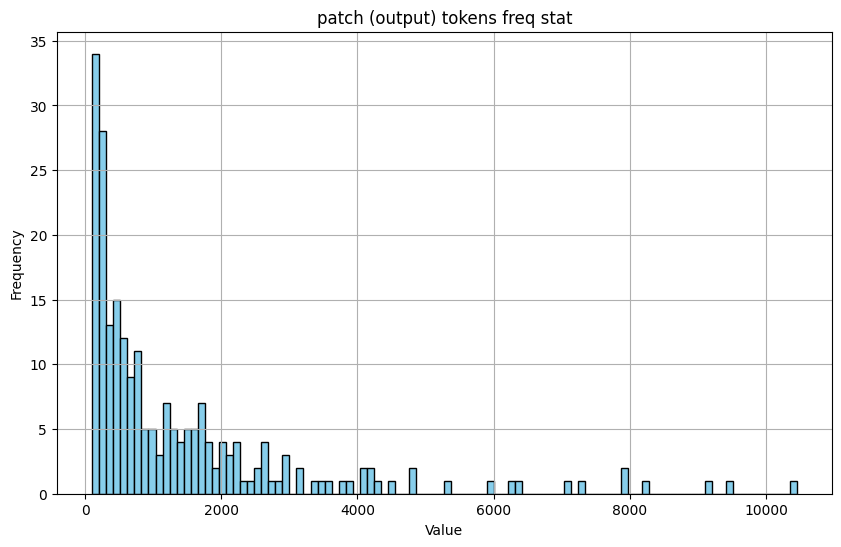

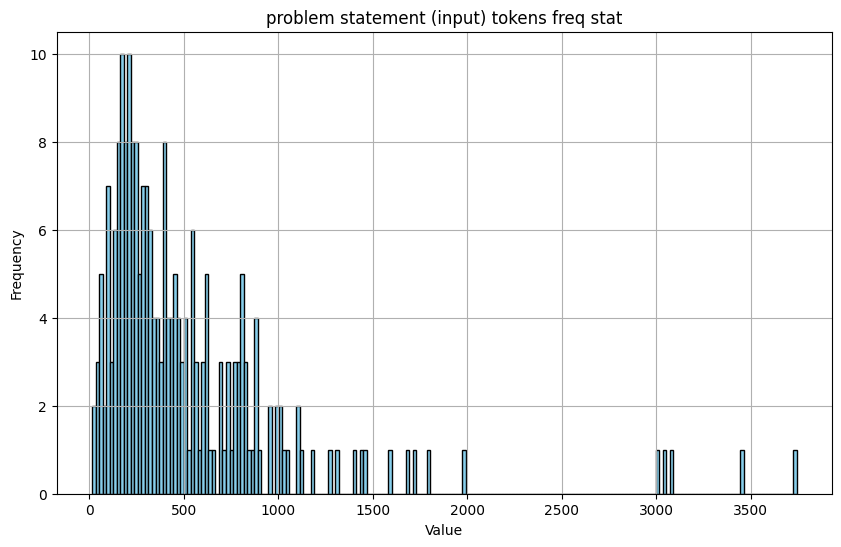

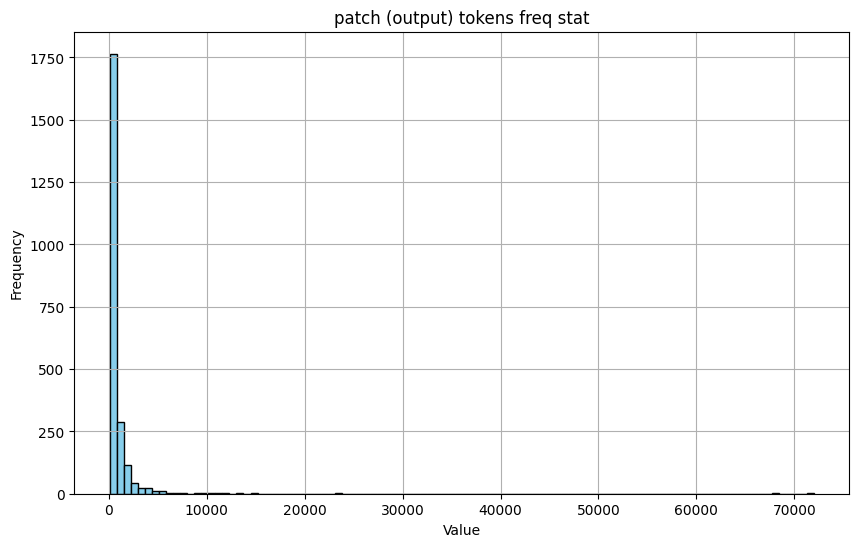

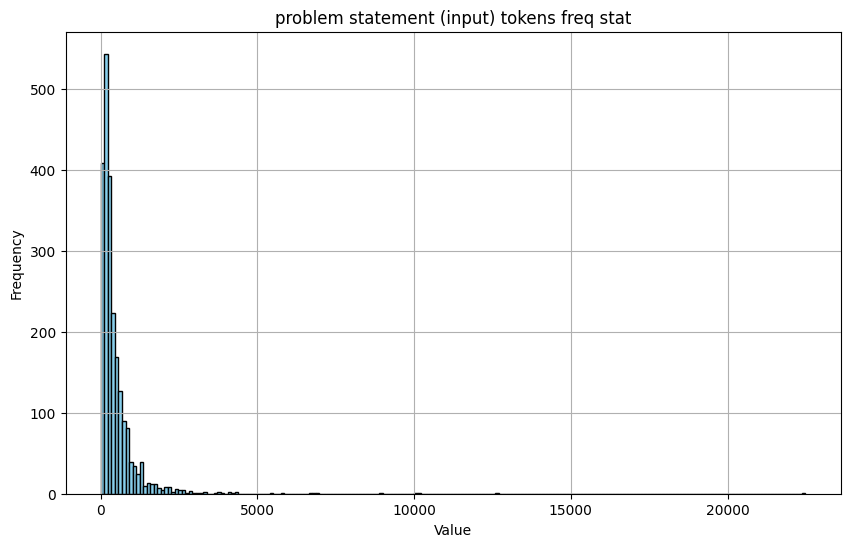

In [26]:
import numpy as np

def plot_histogram_by_bins(data, bins=10, title="Frequency Distribution Histogram", xlabel="Value", ylabel="Frequency"):
    """
    绘制频数分布直方图
    :param data: 数据列表
    :param bins: 直方图的柱数
    :param title: 图表标题
    :param xlabel: x轴标签
    :param ylabel: y轴标签
    """
    # 计算频数和箱边界
    frequencies, bin_edges = np.histogram(data, bins=bins)
    
    # 计算每个箱的中心点
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, frequencies, width=bin_edges[1] - bin_edges[0], color='skyblue', edgecolor='black')
    
    # 添加标题和标签
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)  # 添加网格线
    
# def count_lines_in_patches(patch_str: str):
#     file_changes = []
#     current_file = None
#     lines_added = 0
#     lines_deleted = 0

#     for line in patch_str.split('\n'):
#         # 识别文件变更部分的开始
#         match = re.match(r'^diff --git a/.+ b/(.+)', line)
#         if match:
#             # 如果有正在处理的文件，将其变更统计添加到结果列表中
#             if current_file is not None:
#                 file_changes.append((current_file, lines_deleted, lines_added))
#             # 更新当前文件和行变更计数器
#             current_file = match.group(1)
#             lines_added = 0
#             lines_deleted = 0
#         # 统计添加的行
#         elif line.startswith('+') and not line.startswith('+++'):
#             lines_added += 1
#         # 统计删除的行
#         elif line.startswith('-') and not line.startswith('---'):
#             lines_deleted += 1
    
#     # 处理最后一个文件
#     if current_file is not None:
#         file_changes.append((current_file, lines_deleted, lines_added))
    
#     return file_changes

import tiktoken

def count_tokens(text: str, model_name: str = 'gpt-4o') -> int:
    # 根据模型名称获取编码器
    encoding = tiktoken.encoding_for_model(model_name)
    
    # 编码字符串并返回 token 数量
    tokens = encoding.encode(text)
    return len(tokens)


def describe_tokens(target_ds):
    patch_tokens = []
    statement_tokens = []
    
    for dct in target_ds:
        patch = dct['patch']
        patch_tokens.append(count_tokens(patch))
        statement = dct['problem_statement']
        statement_tokens.append(count_tokens(statement))
        
    plot_histogram_by_bins(patch_tokens, 100, 'patch (output) tokens freq stat')
    plot_histogram_by_bins(statement_tokens, 200, 'problem statement (input) tokens freq stat')


describe_tokens(ds['dev'])
describe_tokens(ds['test'])

In general,
prompt tokens >= 4k, output tokens >= 8k can handle 95% instances 

# Describe the level of modified files

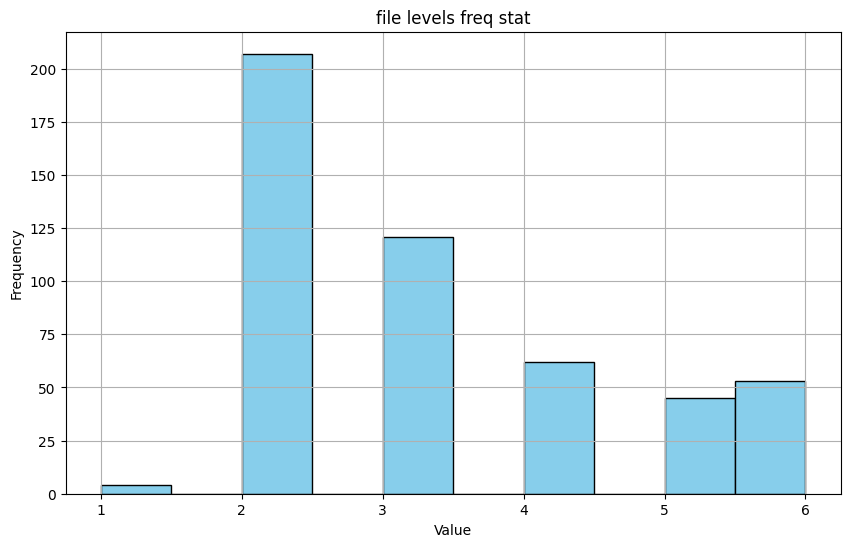

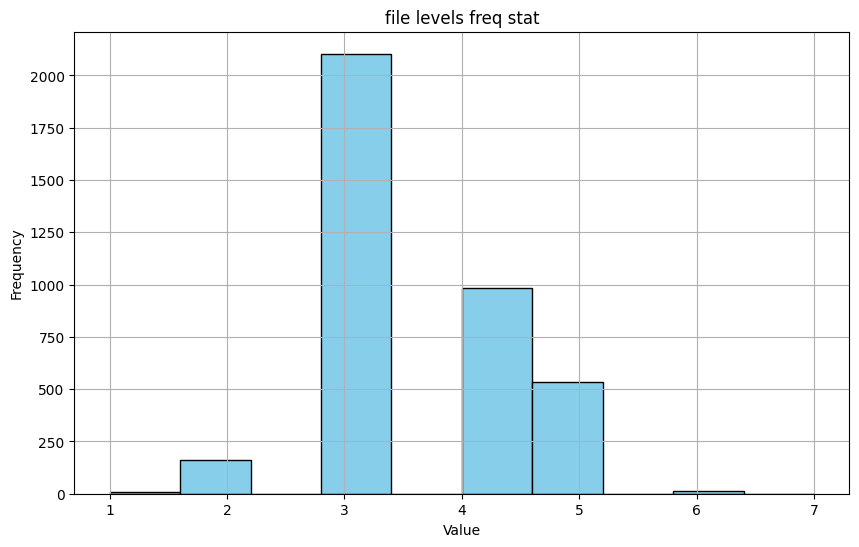

In [27]:
def get_file_level(patch_str: str):
    # 使用正则表达式匹配以 'diff --git' 开头的行
    pattern = re.compile(r'^diff --git a/.+ b/(.+)', re.MULTILINE)
    matches = pattern.findall(patch_str)
    
    # 统计每种类型文件的修改次数
    levels = []
    for match in matches:
        sub_path = match.split('/')
        levels.append(len(sub_path))
    
    # 返回Python文件的修改次数和其他文件的统计信息
    return levels


def describe_level_of_patches(target_ds):
    file_levels = []
    
    for dct in target_ds:
        patch = dct['patch']
        file_levels += get_file_level(patch)

    # print(file_levels)
    plot_histogram_by_bins(file_levels, 10, 'file levels freq stat')

describe_level_of_patches(ds['dev'])
describe_level_of_patches(ds['test'])

In gereneral, the level of modified files are range from 1 to 6